In [1]:
import torch
from torchvision import models 

DeepLabv3 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True).eval()
FCN = models.segmentation.fcn_resnet101(pretrained=True).eval()


Using cache found in /Users/alexwell/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/alexwell/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alexwell/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/alexwell/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The curren

In [5]:
import os
from PIL import Image
from torchvision import transforms

train_img = "../ADEChallengeData2016/annotations/training/"

def get_img_path(path):
    return [f for f in os.listdir(path)]

train_img_list = get_img_path(train_img)
input_image = Image.open(train_img + train_img_list[5])
# input_image = Image.open("deeplab1.png")
input_image = input_image.convert("RGB")
input_image = input_image.resize((224, 224))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
input_batch = input_batch.to('mps')
DeepLabv3.to('mps')
FCN.to('mps')

with torch.no_grad():
    DeepLabv3_output = DeepLabv3(input_batch)['out'][0]
    FCN_output = FCN(input_batch)['out'][0]
    
torch.set_printoptions(profile="full")
DeepLabv3_output_predictions = DeepLabv3_output.argmax(0)
FCN_output_predictions = FCN_output.argmax(0)



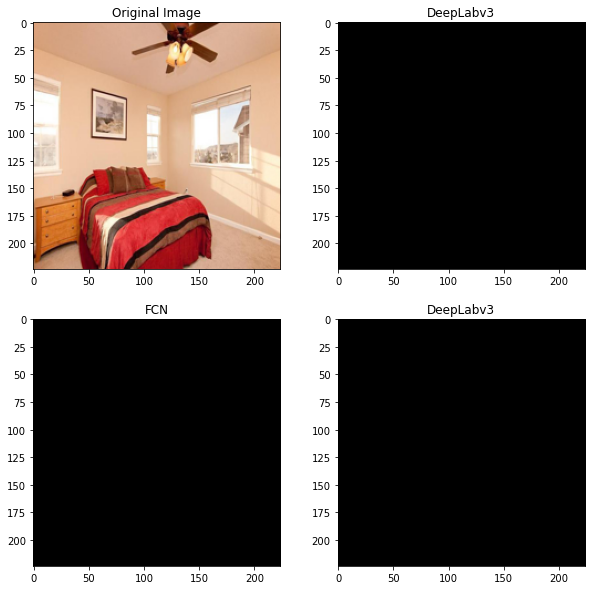

In [13]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
DeepLabv3_r = Image.fromarray(DeepLabv3_output_predictions.byte().cpu().numpy()).resize(input_image.size)
DeepLabv3_r.putpalette(colors)

FCN_r = Image.fromarray(FCN_output_predictions.byte().cpu().numpy()).resize(input_image.size)
FCN_r.putpalette(colors)

import matplotlib.pyplot as plt
# plt.imshow(r)
# plt.imshow(input_image)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title("Original Image")
ax2 = fig.add_subplot(2,2,2)
ax2.set_title("DeepLabv3")
ax3 = fig.add_subplot(2,2,3)
ax3.set_title("FCN")
ax4 = fig.add_subplot(2,2,4)
ax4.set_title("DeepLabv3")

ax1.imshow(input_image)
ax2.imshow(DeepLabv3_r)
ax3.imshow(FCN_r)
ax4.imshow(DeepLabv3_r)
plt.show()